<a href="https://colab.research.google.com/github/EiffL/LPTLensingComparison/blob/main/notebooks/LPTLensingPrecisionTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/jax_cosmo.git
!pip install --quiet numpyro
!pip install lenstools cmasher
!pip install --quiet --user git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git git+https://github.com/DifferentiableUniverseInitiative/sbi_lens.git
!pip install --quiet --user jax_cosmo numpyro chainconsumer

In [1]:
%pylab inline
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.95'

import jax
import jax.numpy as jnp
import jax_cosmo as jc

import numpyro
from numpyro.handlers import seed, trace, condition
import numpyro.distributions as dist

import tensorflow_probability as tfp; tfp = tfp.substrates.jax
tfd= tfp.distributions

import cmasher as cmr

Populating the interactive namespace from numpy and matplotlib


In [2]:
%pylab inline
import h5py
import jax
import jax.numpy as jnp
import jax_cosmo as jc
from jax_cosmo.scipy.integrate import simps
import astropy.units as u
from chainconsumer import ChainConsumer
import numpyro
import numpyro.distributions as dist

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['trace', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
#@title Run Me

# This module contains utility functions to run a forward simulation using an LPT lightcone
import jax
import jax.numpy as jnp

import jax_cosmo as jc

import numpyro
import numpyro.distributions as dist

from jax.experimental.ode import odeint
from jaxpm.pm import lpt, make_ode_fn, pm_forces, growth_factor, growth_rate, dGfa
from jaxpm.kernels import fftk
from jaxpm.lensing import density_plane

from jaxpm.painting import cic_paint, cic_read, cic_paint_2d, compensate_cic
from jaxpm.kernels import gradient_kernel, laplace_kernel, longrange_kernel
from jaxpm.utils import gaussian_smoothing

from jax.scipy.ndimage import map_coordinates
from jaxpm.utils import gaussian_smoothing
import jax_cosmo.constants as constants

def linear_field(mesh_shape, box_size, pk, field):
  """
    Generate initial conditions.
    """
  kvec = fftk(mesh_shape)
  kmesh = sum(
      (kk / box_size[i] * mesh_shape[i])**2 for i, kk in enumerate(kvec))**0.5
  pkmesh = pk(kmesh) * (mesh_shape[0] * mesh_shape[1] * mesh_shape[2]) / (
      box_size[0] * box_size[1] * box_size[2])

  field = jnp.fft.rfftn(field) * pkmesh**0.5
  field = jnp.fft.irfftn(field)
  return field

def lpt_lightcone(cosmo, initial_conditions, positions, a, mesh_shape):
    """
    Computes first order LPT displacement
    """
    initial_force = pm_forces(positions, delta=initial_conditions).reshape(mesh_shape+[3])
    a = jnp.atleast_1d(a)
    dx = growth_factor(cosmo, a).reshape([1,1,-1,1]) * initial_force
    p = (a**2 * growth_rate(cosmo, a) * jnp.sqrt(jc.background.Esqr(cosmo, a))).reshape([1,1,-1,1]) * dx
    f = (a**2 * jnp.sqrt(jc.background.Esqr(cosmo, a)) * dGfa(cosmo, a)).reshape([1,1,-1,1]) * initial_force
    return dx.reshape([-1,3]), p.reshape([-1,3]), f.reshape([-1,3])

def convergence_Born(cosmo,
                     density_planes,
                     r,
                     a,
                     dx,
                     dz,
                     coords,
                     z_source):
  """
  Compute the Born convergence
  Args:
    cosmo: `Cosmology`, cosmology object.
    density_planes: list of dictionaries (r, a, density_plane, dx, dz), lens planes to use
    coords: a 3-D array of angular coordinates in radians of N points with shape [batch, N, 2].
    z_source: 1-D `Tensor` of source redshifts with shape [Nz] .
    name: `string`, name of the operation.
  Returns:
    `Tensor` of shape [batch_size, N, Nz], of convergence values.
  """
  # Compute constant prefactor:
  constant_factor = 3 / 2 * cosmo.Omega_m * (constants.H0 / constants.c)**2
  # Compute comoving distance of source galaxies
  r_s = jc.background.radial_comoving_distance(cosmo, 1 / (1 + z_source))

  convergence = 0
  n_planes = len(r)

  def scan_fn(carry, i):
    density_planes, a, r = carry

    p = density_planes[:,:,i]
    density_normalization = dz * r[i] / a[i]
    p = (p - p.mean()) * constant_factor * density_normalization

    # Interpolate at the density plane coordinates
    im = map_coordinates(p,
                         coords * r[i] / dx - 0.5,
                         order=1, mode="wrap")

    return carry, im * jnp.clip(1. - (r[i] / r_s), 0, 1000).reshape([-1, 1, 1])

  _, convergence = jax.lax.scan(scan_fn, (density_planes, a, r), jnp.arange(n_planes))

  return convergence.sum(axis=0)

In [4]:
# load lsst year 10 settings
from sbi_lens.config import config_lsst_y_10
from sbi_lens.simulator.redshift import subdivide

N                = config_lsst_y_10.N
map_size         = 5 # 5 deg like kappaTNG
sigma_e          = config_lsst_y_10.sigma_e
gals_per_arcmin2 = config_lsst_y_10.gals_per_arcmin2
nbins            = config_lsst_y_10.nbins
a                = config_lsst_y_10.a
b                = config_lsst_y_10.b
z0               = config_lsst_y_10.z0

In [5]:
# Define redshift distribution
nz = jc.redshift.smail_nz(a, b, z0, gals_per_arcmin2=gals_per_arcmin2, zmax=2.6)
nz_shear = subdivide(nz, nbins=nbins, zphot_sigma=0.05)

z = linspace(0, 3., 128)

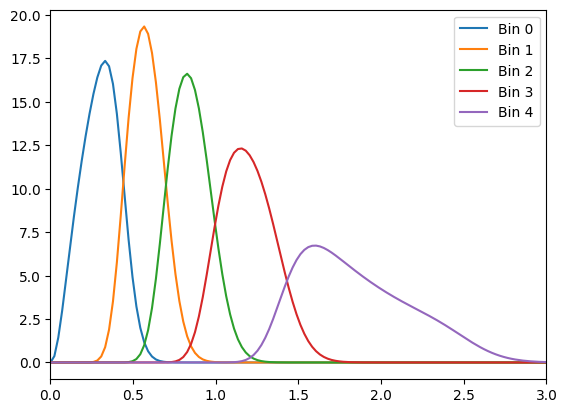

In [6]:
for i in range(nbins):
  plot(z, nz_shear[i](z)*nz_shear[i].gals_per_arcmin2, color='C%d'%i, label="Bin %d"%i)
legend()
xlim(0,3);

In [76]:
# Low resolution settings:
# box_size=[1000., 1000., 4000.] # In Mpc/h
# nc = [64, 64, 256]             # Number of pixels

# High resolution settings
# Note: this low resolution on the los impacts a tiny bit the cross-correlation signal,
# but it's probably worth it in terms of speed gains
box_size=[400., 400., 4000.]   # In Mpc/h
nc = [256, 256, 128]           # Number of pixels

field_size = map_size          # Size of the lensing field in degrees
field_npix = 64                # Number of pixels in the lensing field
sigma_e = sigma_e              # Standard deviation of galaxy ellipticities

@jax.jit
def forward_model(omega_c, sigma_8, omega_b, h_0, n_s, w_0, initial_conditions):
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling cosmological parameters and defines cosmology
  cosmo = jc.Cosmology(Omega_c=omega_c, sigma8=sigma_8, Omega_b=omega_b,
                       h=h_0, n_s=n_s, w0=w_0, Omega_k=0., wa=0.)

  # Create a small function to generate the matter power spectrum
  k = jnp.logspace(-4, 1, 128)
  pk = jc.power.linear_matter_power(cosmo, k)
  pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape([-1]), k, pk).reshape(x.shape)

  # Create initial conditions
  lin_field = linear_field(nc, box_size, pk_fn, initial_conditions)

  # Create particles
  particles = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in nc]),axis=-1).reshape([-1,3])

  # Compute the scale factor that corresponds to each slice of the volume
  r = (jnp.arange(nc[-1]) + 0.5)*box_size[-1]/nc[-1]
  a = jc.background.a_of_chi(cosmo, r)

  cosmo = jc.Cosmology(Omega_c=omega_c, sigma8=sigma_8, Omega_b=omega_b,
                       h=h_0, n_s=n_s, w0=w_0, Omega_k=0., wa=0.)
  # Initial displacement
  dx, p, f = lpt_lightcone(cosmo, lin_field, particles, a, nc)

  # Paint the particles on a new mesh
  lightcone = cic_paint(jnp.zeros(nc),  particles+dx)
  # Apply de-cic filter to recover more signal on small scales
  lightcone = compensate_cic(lightcone)

  dx = box_size[0] / nc[0]
  dz = box_size[-1] / nc[-1]

  # Defining the coordinate grid for lensing map
  xgrid, ygrid = np.meshgrid(np.linspace(0, field_size, nc[0], endpoint=False), # range of X coordinates
                             np.linspace(0, field_size, nc[1], endpoint=False)) # range of Y coordinates
  coords = jnp.array((np.stack([xgrid, ygrid], axis=0)*u.deg).to(u.rad))

  # Generate convergence maps by integrating over nz and source planes
  convergence_maps = [simps(lambda z: nz(z).reshape([-1,1,1]) *
                              convergence_Born(cosmo, lightcone, r,a, dx, dz, coords, z), 0.01, 3.0, N=32)
                      for nz in nz_shear]

  # Reshape the maps to desired resoluton
  convergence_maps = [kmap.reshape([field_npix, nc[0] // field_npix,  field_npix, nc[1] // field_npix ]).mean(axis=1).mean(axis=-1)
                      for kmap in convergence_maps]

  return convergence_maps, lightcone


def model():
  """
  This function defines the top-level forward model for our observations
  """
  # Sampling initial conditions
  initial_conditions = numpyro.sample(
      'initial_conditions',
      dist.Normal(jnp.zeros(nc), jnp.ones(nc)))

  # Sampling cosmological parameters and defines cosmology
  omega_c = numpyro.sample("omega_c", dist.TruncatedNormal(0.2664, 0.2, low=0))
  omega_b = numpyro.sample("omega_b", dist.Normal(0.0492, 0.006))
  sigma_8 = numpyro.sample("sigma_8", dist.Normal(0.831, 0.14))
  h_0 = numpyro.sample("h_0", dist.Normal(0.6727, 0.063))
  n_s = numpyro.sample("n_s", dist.Normal(0.9645, 0.08))
  w_0 = numpyro.sample("w_0", dist.TruncatedNormal(-1.0, 0.9, low=-2.0, high=-0.3))

  convergence_maps, _ = forward_model(omega_c, sigma_8, omega_b, h_0, n_s, w_0, initial_conditions)

  # Apply noise to the maps (this defines the likelihood)
  observed_maps = [numpyro.sample('kappa_%d'%i,
                                  dist.Normal(k, sigma_e/jnp.sqrt(nz_shear[i].gals_per_arcmin2*(field_size*60/field_npix)**2)))
                   for i,k in enumerate(convergence_maps)]

  return observed_maps

In [77]:
# condition the model on a given set of parameters
fiducial_model = numpyro.handlers.condition(model, {'omega_c': 0.3,
                                                    'omega_b': 0.0492,
                                                    'sigma_8': 0.8,
                                                    'h_0': 0.7,
                                                    'n_s': 0.9,
                                                    'w_0': -1.0})

# sample a mass map and save corresponding true parameters
model_tracer = numpyro.handlers.trace(numpyro.handlers.seed(fiducial_model, jax.random.PRNGKey(1234)))
model_trace = model_tracer.get_trace()

<ipython-input-3-d3e02e4e5608>:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  kmesh = sum(


In [78]:
theta_max=map_size
EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)
cmap = cmr.eclipse

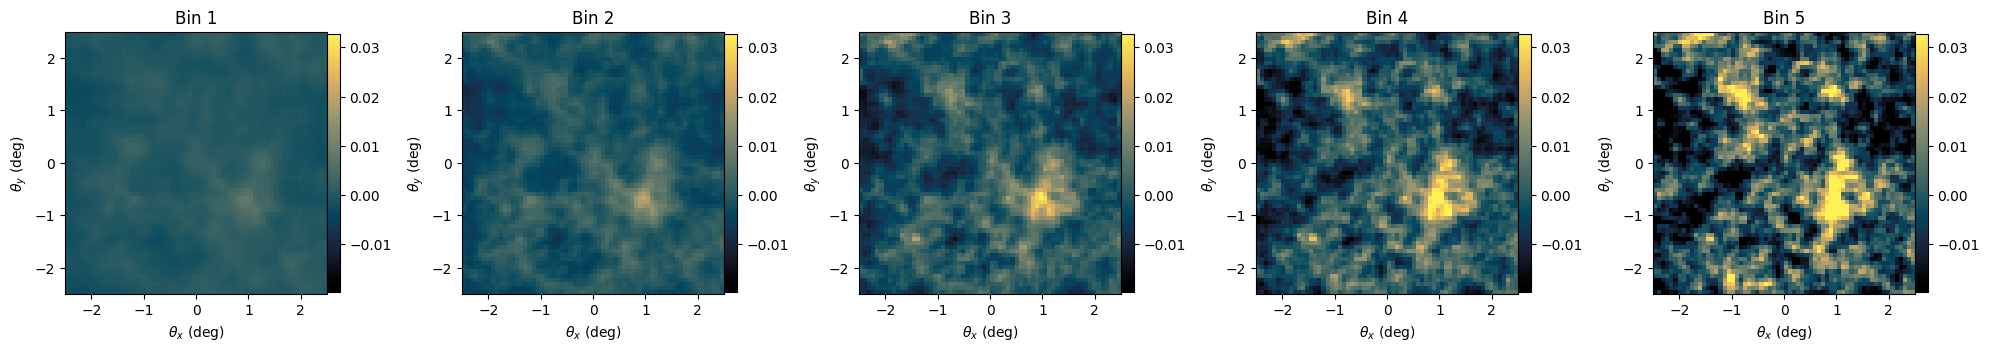

In [79]:
n_nz_bins=5
fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))
for i in range(n_nz_bins):
    std_kmap = np.std(model_trace['kappa_4']['fn'].mean)
    ax[i].set_title('Bin %d'%(i+1))
    ax[i].set_xlabel(r'$\theta_x$ (deg)')
    ax[i].set_ylabel(r'$\theta_y$ (deg)')
    cb = fig.colorbar(ax[i].imshow(model_trace['kappa_%d'%i]['fn'].mean, cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
    cb.ax.tick_params(labelsize=10)
plt.tight_layout()
plt.show()

### Create N mock realization to average over the final angular power spectrum

Sample 1


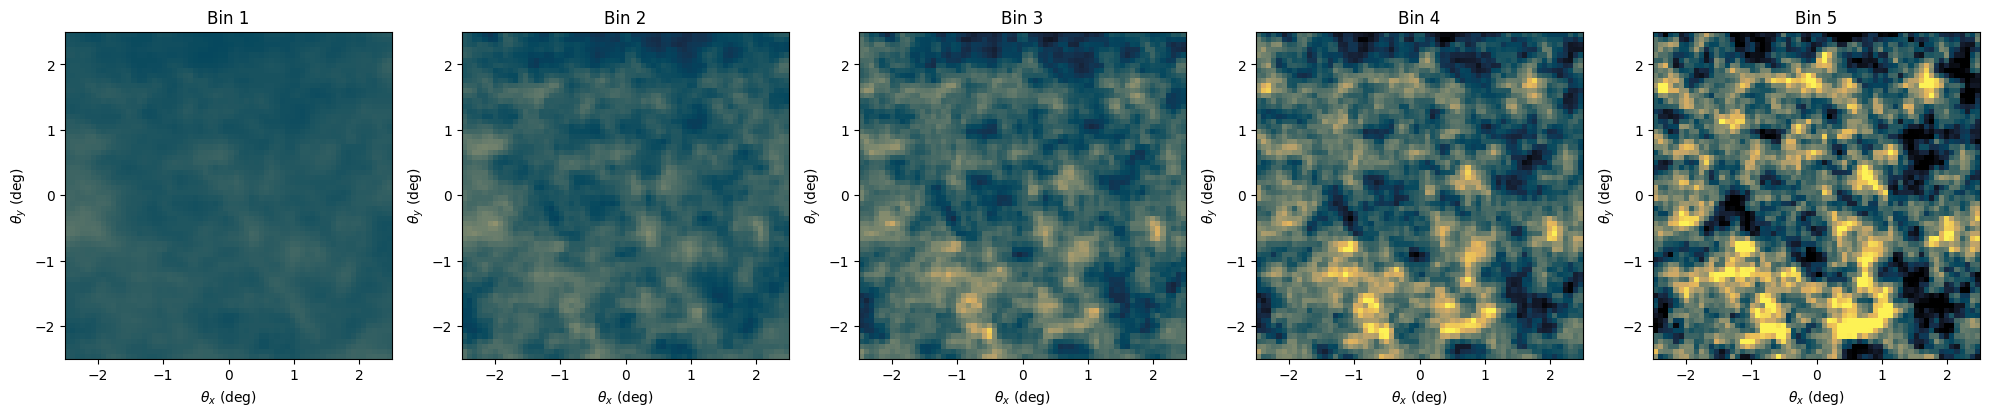

Sample 2


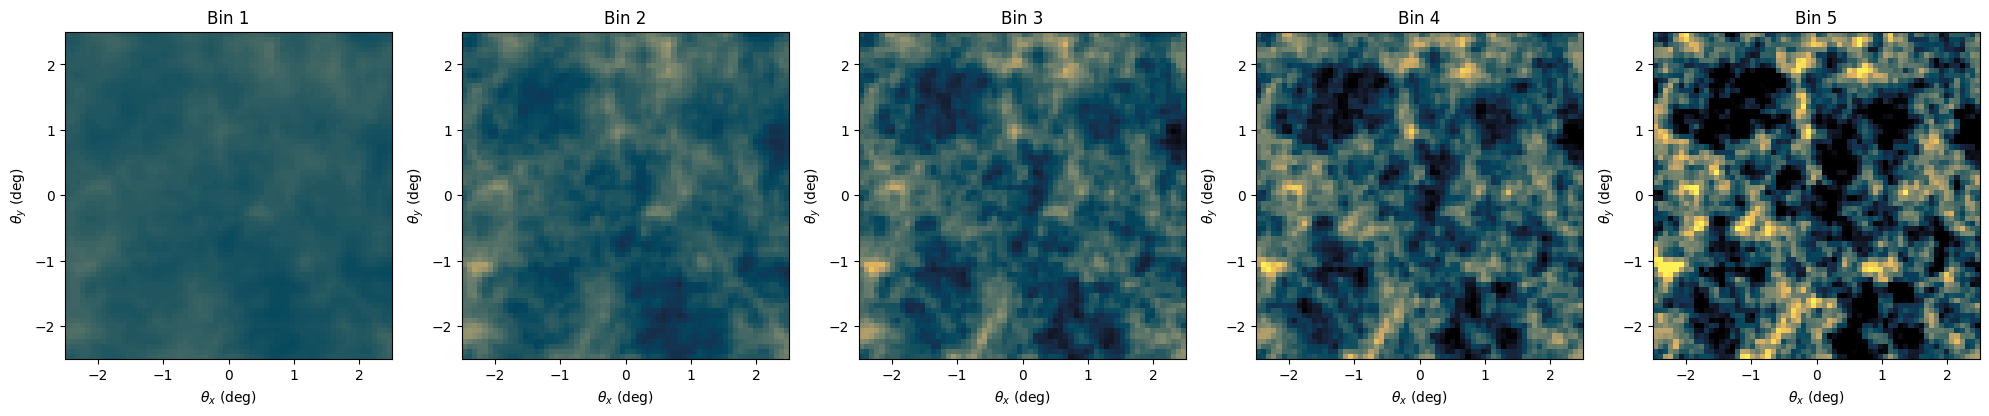

Sample 3


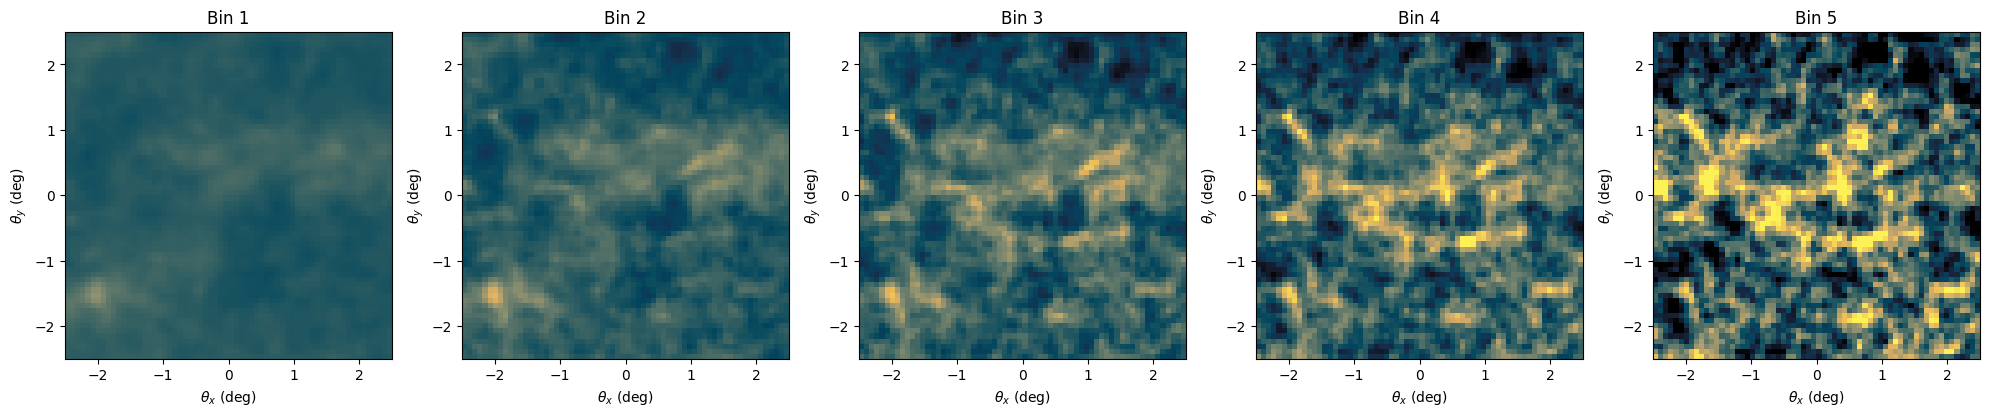

Sample 4


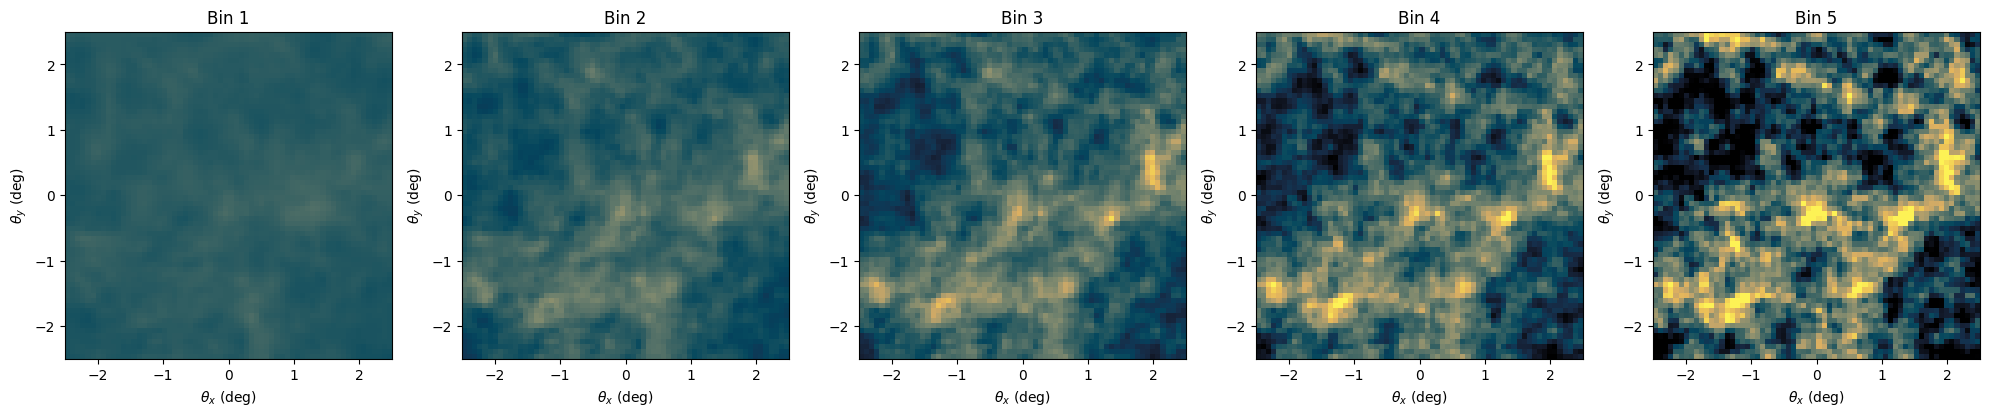

Sample 5


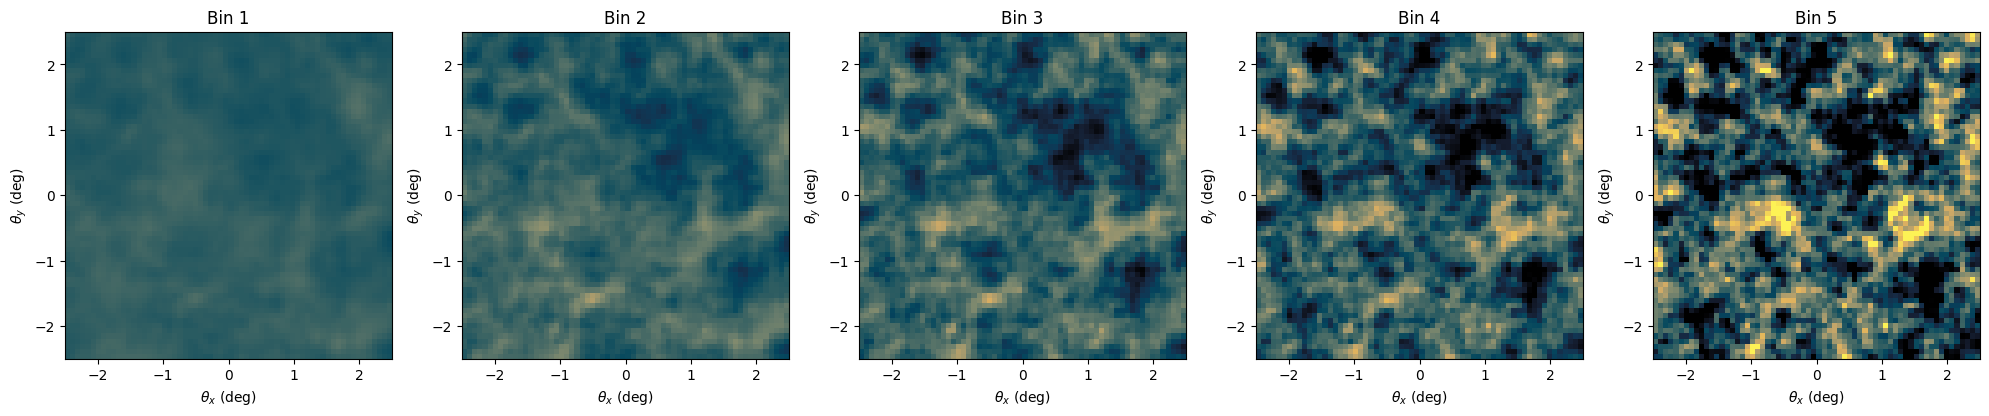

Sample 6


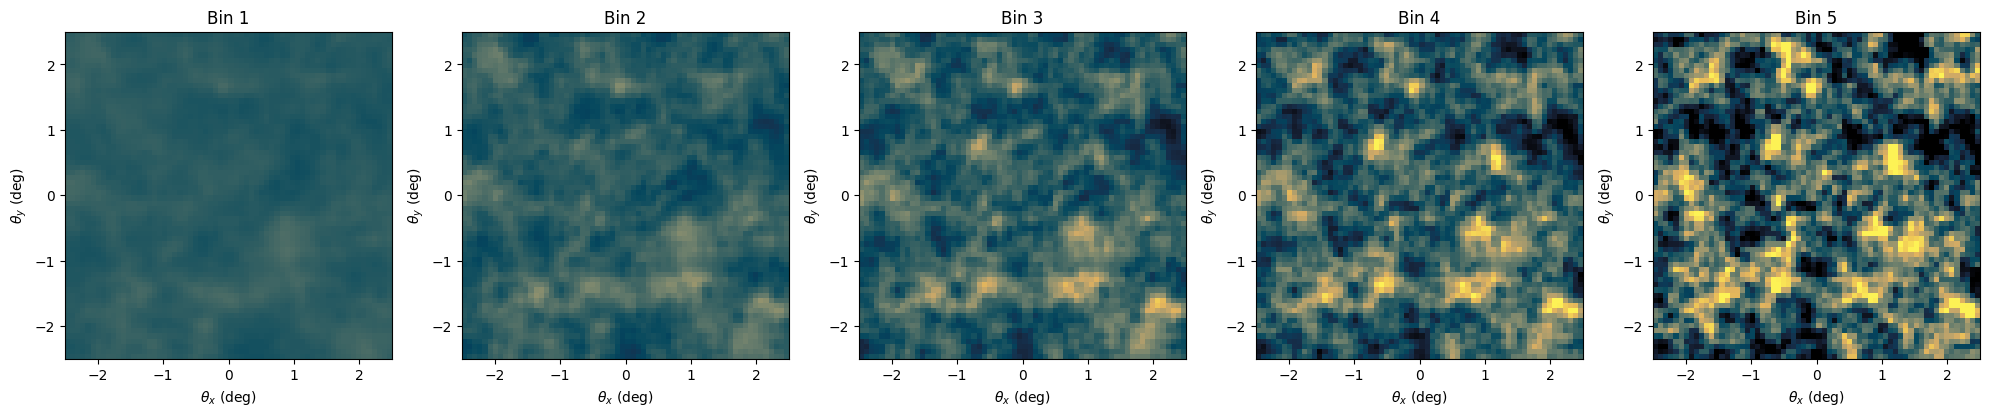

Sample 7


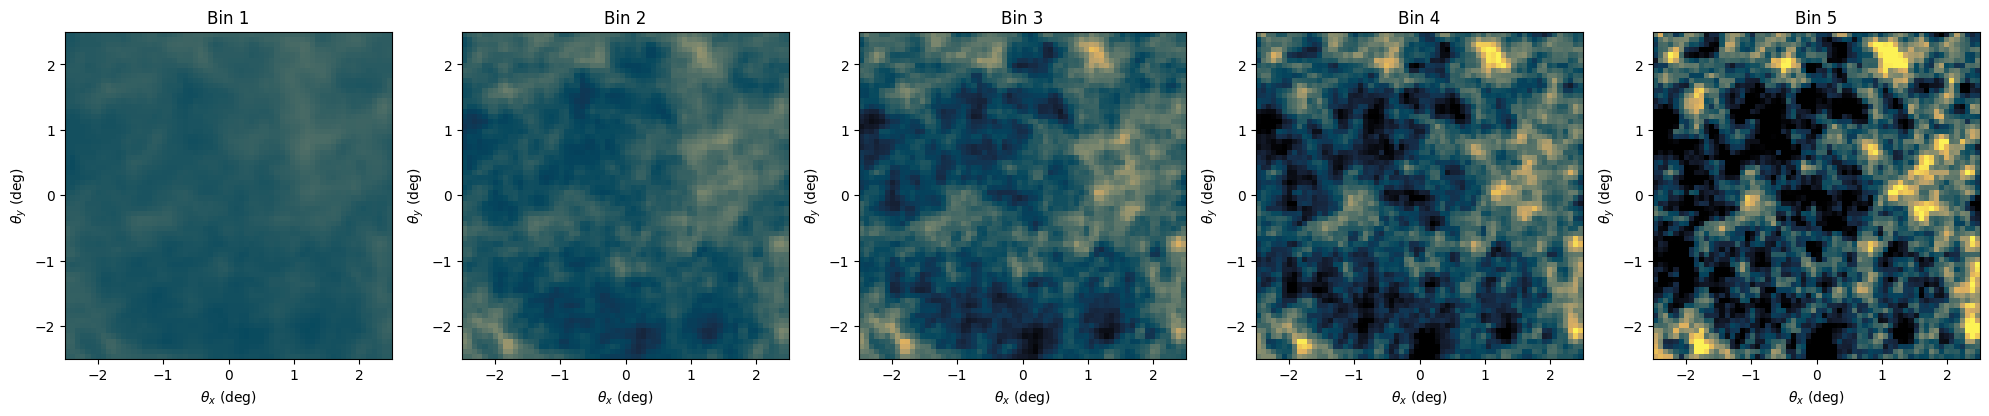

Sample 8


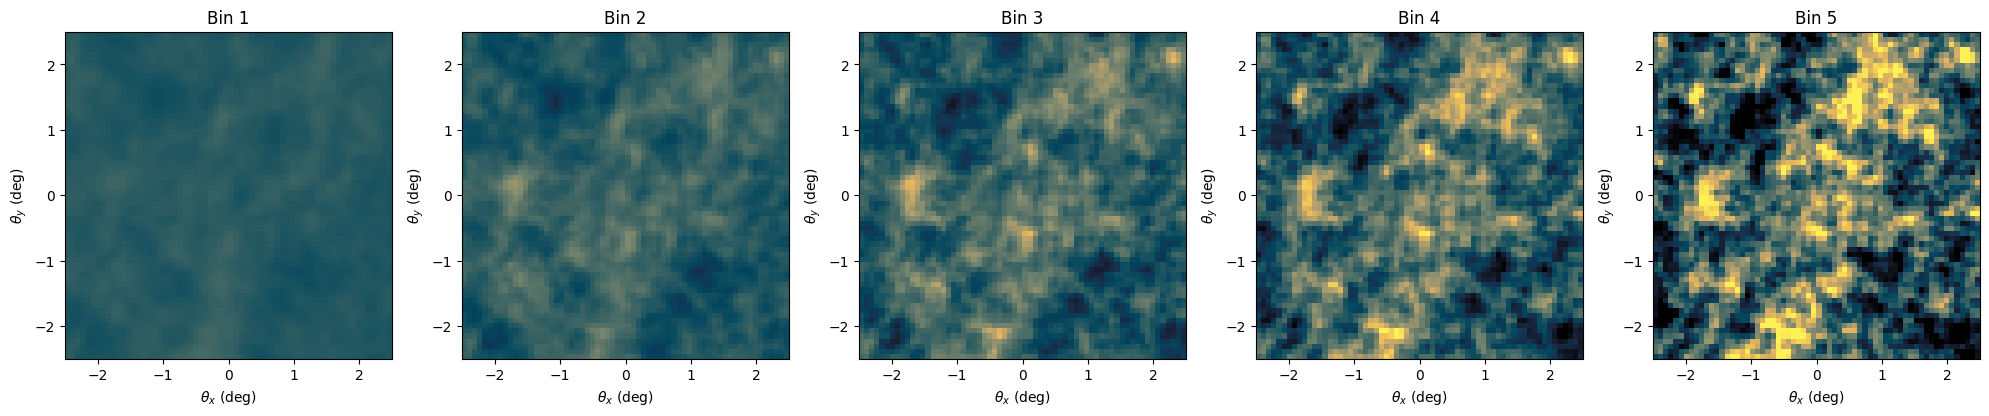

Sample 9


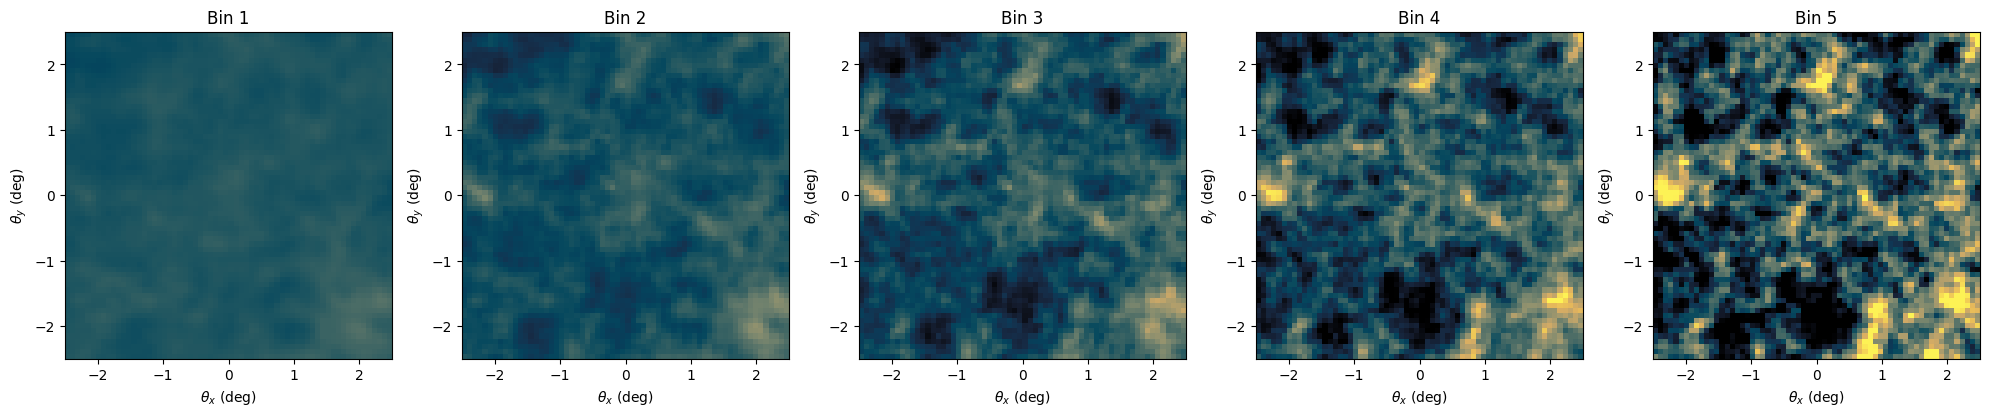

Sample 10


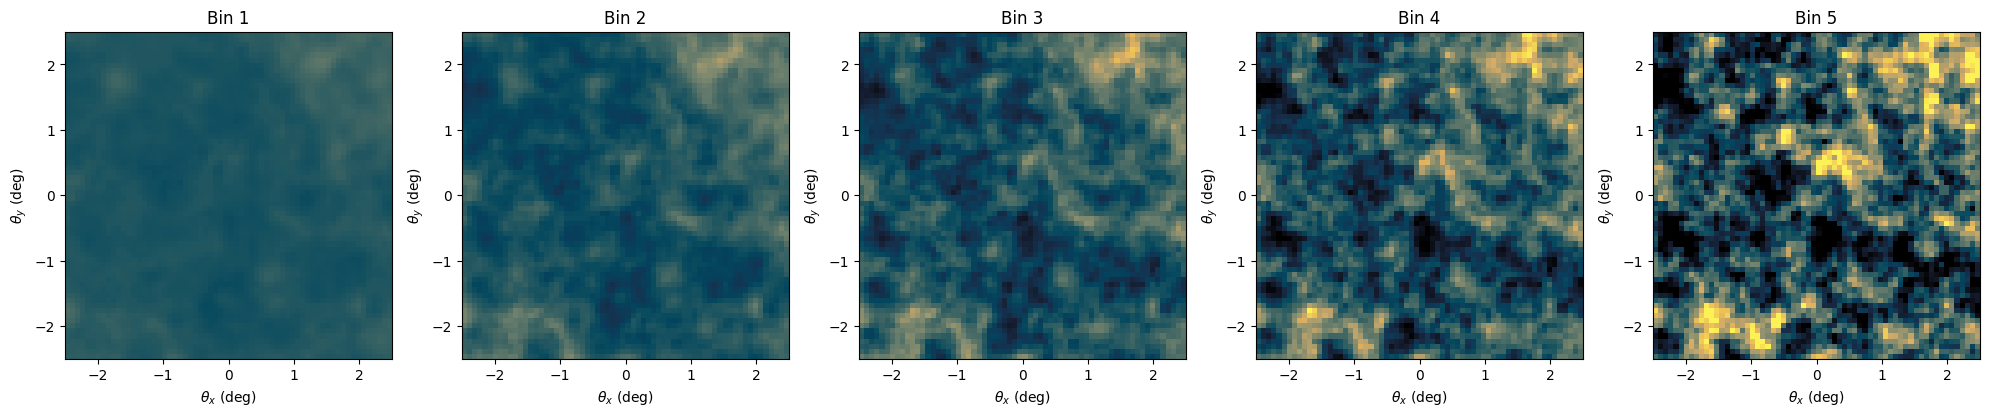

In [80]:
N_sample = 10

Cl_list = []
for i in range(N_sample):
    print("===================================================")
    print("Sample %d"%(i+1))
    print("===================================================")

    model_trace = model_tracer.get_trace()
    m_data = jnp.stack([model_trace['kappa_0']['fn'].mean,
                        model_trace['kappa_1']['fn'].mean,
                        model_trace['kappa_2']['fn'].mean,
                        model_trace['kappa_3']['fn'].mean,
                        model_trace['kappa_4']['fn'].mean], axis=0)
    Cl_list.append(m_data)

    fig, ax = plt.subplots(1,n_nz_bins, figsize=(4 * n_nz_bins, 7))

    EXTENT = (-0.5 * theta_max, 0.5 * theta_max, -0.5 * theta_max, 0.5 * theta_max)

    for i in range(n_nz_bins):
        std_kmap = np.std(m_data[-1])
        ax[i].set_title('Bin %d'%(i+1))
        ax[i].set_xlabel(r'$\theta_x$ (deg)')
        ax[i].set_ylabel(r'$\theta_y$ (deg)')
        ax[i].imshow(m_data[i],cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT)
        # cb = fig.colorbar(ax[i].imshow(m_data[i],cmap=cmap, vmin = -1.5 * std_kmap, vmax = 2.5 * std_kmap, extent=EXTENT) ,fraction=0.047, pad=0.)
        cb.ax.tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

### Compare the results with the theory

In [81]:
from lenstools import ConvergenceMap
import astropy.units as u
import itertools
import cmasher as cmr

In [82]:
def pixel_window_function(l, pixel_size_arcmin):
    """
    Calculate the pixel window function W_l for a given angular wave number l and pixel size.

    Parameters:
    - l: Angular wave number (can be a numpy array or a single value).
    - pixel_size_arcmin: Pixel size in arcminutes.

    Returns:
    - W_l: Pixel window function for the given l and pixel size.
    """
    # Convert pixel size from arcminutes to radians
    pixel_size_rad = pixel_size_arcmin * (np.pi / (180.0 * 60.0))

    # Calculate the Fourier transform of the square pixel (sinc function)
    # Note: l should be the magnitude of the angular wave number vector, |l| = sqrt(lx^2 + ly^2) for a general l
    # For simplicity, we assume l is already provided as |l|
    W_l = (jnp.sinc(l * pixel_size_rad / (2 * np.pi)))**2

    return W_l

In [83]:
ell_theory = jnp.linspace(100, 5000, 128)
cosmo = jc.Planck15(Omega_c=0.3, sigma8=0.8, h=0.7, n_s=0.9, w0=-1., Omega_b=0.0492)
tracer = jc.probes.WeakLensing(nz_shear)
cell_theory = jc.angular_cl.angular_cl(cosmo, ell_theory, [tracer], nonlinear_fn=jc.power.linear) # Careful, note that we are only using linear power
cell_noise = jc.angular_cl.noise_cl(ell_theory,[tracer])

# Applying window function
cell_theory = cell_theory * pixel_window_function(ell_theory,
                                                  field_size*60/field_npix)

In [84]:
l_edges_kmap= np.linspace(100, 5000, 128)
lis=[0,1,2,3,4]
p_cross_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_cross=[]
    for i, j in itertools.combinations(lis, 2):
        pi=ConvergenceMap(m_data[i], angle=map_size*u.deg).cross(ConvergenceMap(m_data[j], angle=map_size*u.deg),l_edges=l_edges_kmap)[1]
        p_cross.append(pi)
    p_cross_sample.append(p_cross)
ell_sample=ConvergenceMap(m_data[0], angle=map_size*u.deg).cross(ConvergenceMap(m_data[0], angle=map_size*u.deg),l_edges=l_edges_kmap)[0]

In [85]:
p_auto_sample=[]
for k in range(N_sample):
    m_data=Cl_list[k]
    p_auto=[]
    for i in range(n_nz_bins):
        pi=ConvergenceMap(m_data[i], angle=map_size*u.deg).powerSpectrum(l_edges_kmap)[1]
        p_auto.append(pi)
    p_auto_sample.append(p_auto)

In [86]:
#some useful functions to make the plot
def fill_lower_and_diag(array,nl):
    n = int(np.sqrt(len(array)*2))
    mask = np.arange(n)[:,None] >= np.arange(n)
    out = np.zeros((n,n,nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T


def fill_lower_diag(array,nl):
    n = int(np.sqrt(len(array)*2))+1
    mask = np.arange(n)[:,None] > np.arange(n)
    out = np.zeros((n,n, nl),dtype=float64)
    out[np.stack(mask,axis=1)] = array
    return out.T

n_z_bins=len(nz_shear)

In [87]:
Cl_cross_arr = np.array(p_cross_sample)
Cl_mean_cross  = np.mean(Cl_cross_arr, axis=0)
Cl_lower_cross = np.percentile(Cl_cross_arr, 2.5, axis=0)
Cl_upper_cross = np.percentile(Cl_cross_arr, 97.5, axis=0)

In [88]:
Cl_auto_arr = np.array(p_auto_sample)
Cl_mean_auto  = np.mean(Cl_auto_arr, axis=0)
Cl_lower_auto = np.percentile(Cl_auto_arr, 2.5, axis=0)
Cl_upper_auto = np.percentile(Cl_auto_arr, 97.5, axis=0)

In [89]:
Cl_mean_sample_cross=fill_lower_diag(Cl_mean_cross,127)
Cl_lower_sample_cross=fill_lower_diag(Cl_lower_cross,127)
Cl_upper_sample_cross=fill_lower_diag(Cl_upper_cross,127)

In [90]:
Cl_mean_theory=fill_lower_and_diag(cell_theory,128)

In [91]:
Cl_noise_theory=fill_lower_and_diag(cell_noise,128)

In [92]:
col = cmr.eclipse([0.,0,0.55,0.85])

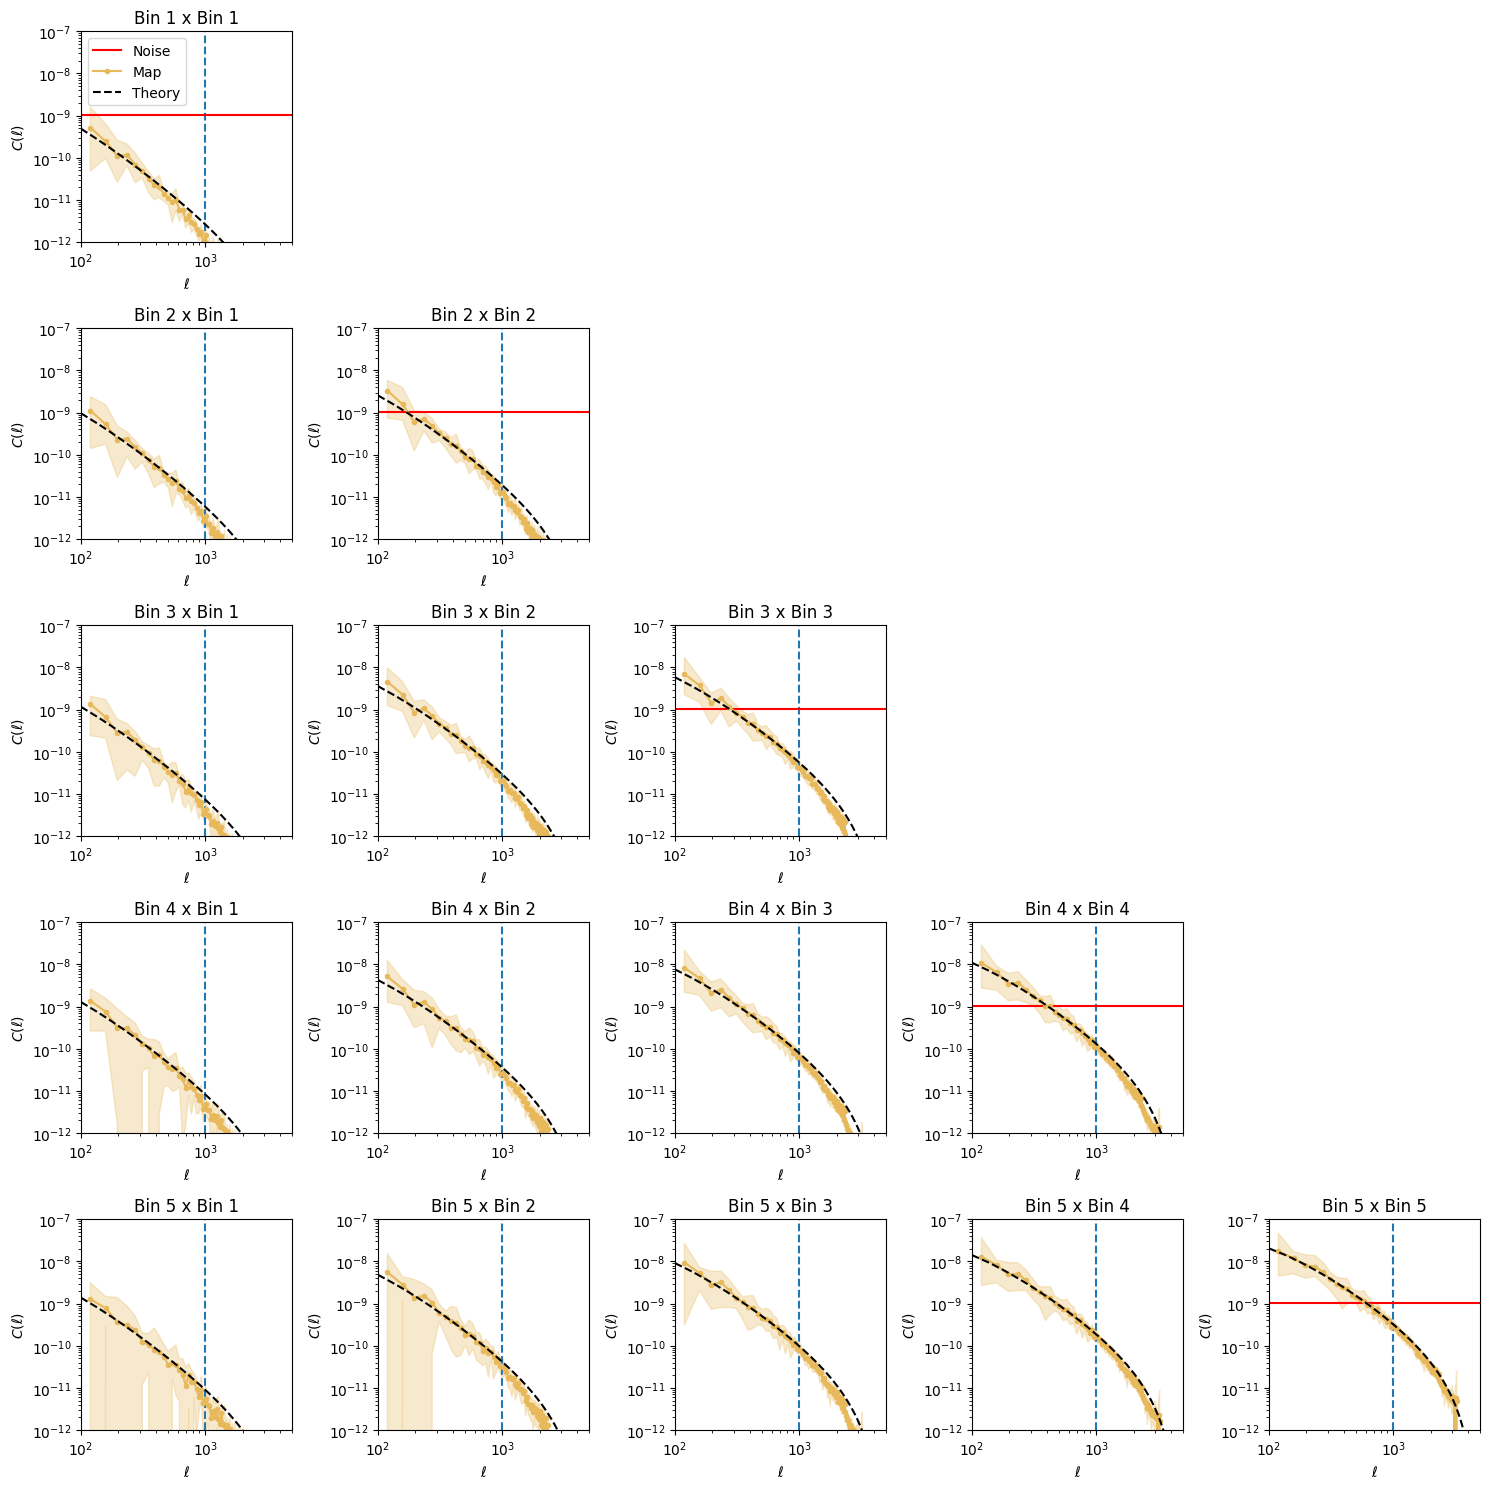

In [93]:
# 256 resolution - linear matter power theory - 64 pixels
fig, ax = plt.subplots(n_z_bins, n_z_bins, figsize=(15,15))

for i in range(n_z_bins):
    for j in range(n_z_bins):
        if(j>i):
            ax[i,j].axis('off')
        else:
            ax[i,j].set_title('Bin %d x Bin %d'%(i+1,j+1))
            ax[i,j].set_xlabel('$\ell$')
            ax[i,j].set_ylabel('$C(\ell)$')
            ax[i,j].set_xlim(100., 5000.)
            ax[i,j].set_ylim(1e-12, 1e-7)
            ax[i,j].axvline(1000, ls='--')
            ax[i,j].loglog(ell_theory, Cl_noise_theory[:,i,j], label='Noise', color='red')
            if i==j:
                ax[i,j].loglog(ell_sample, Cl_mean_auto[i], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_auto[i], Cl_upper_auto[i], color=col[3], alpha=0.3)
            else:
                ax[i,j].loglog(ell_sample, Cl_mean_sample_cross[:,i,j], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_sample_cross[:, i,j], Cl_upper_sample_cross[:,i,j], color=col[3], alpha=0.3)

ax[0,0].legend()
plt.tight_layout()
plt.show()

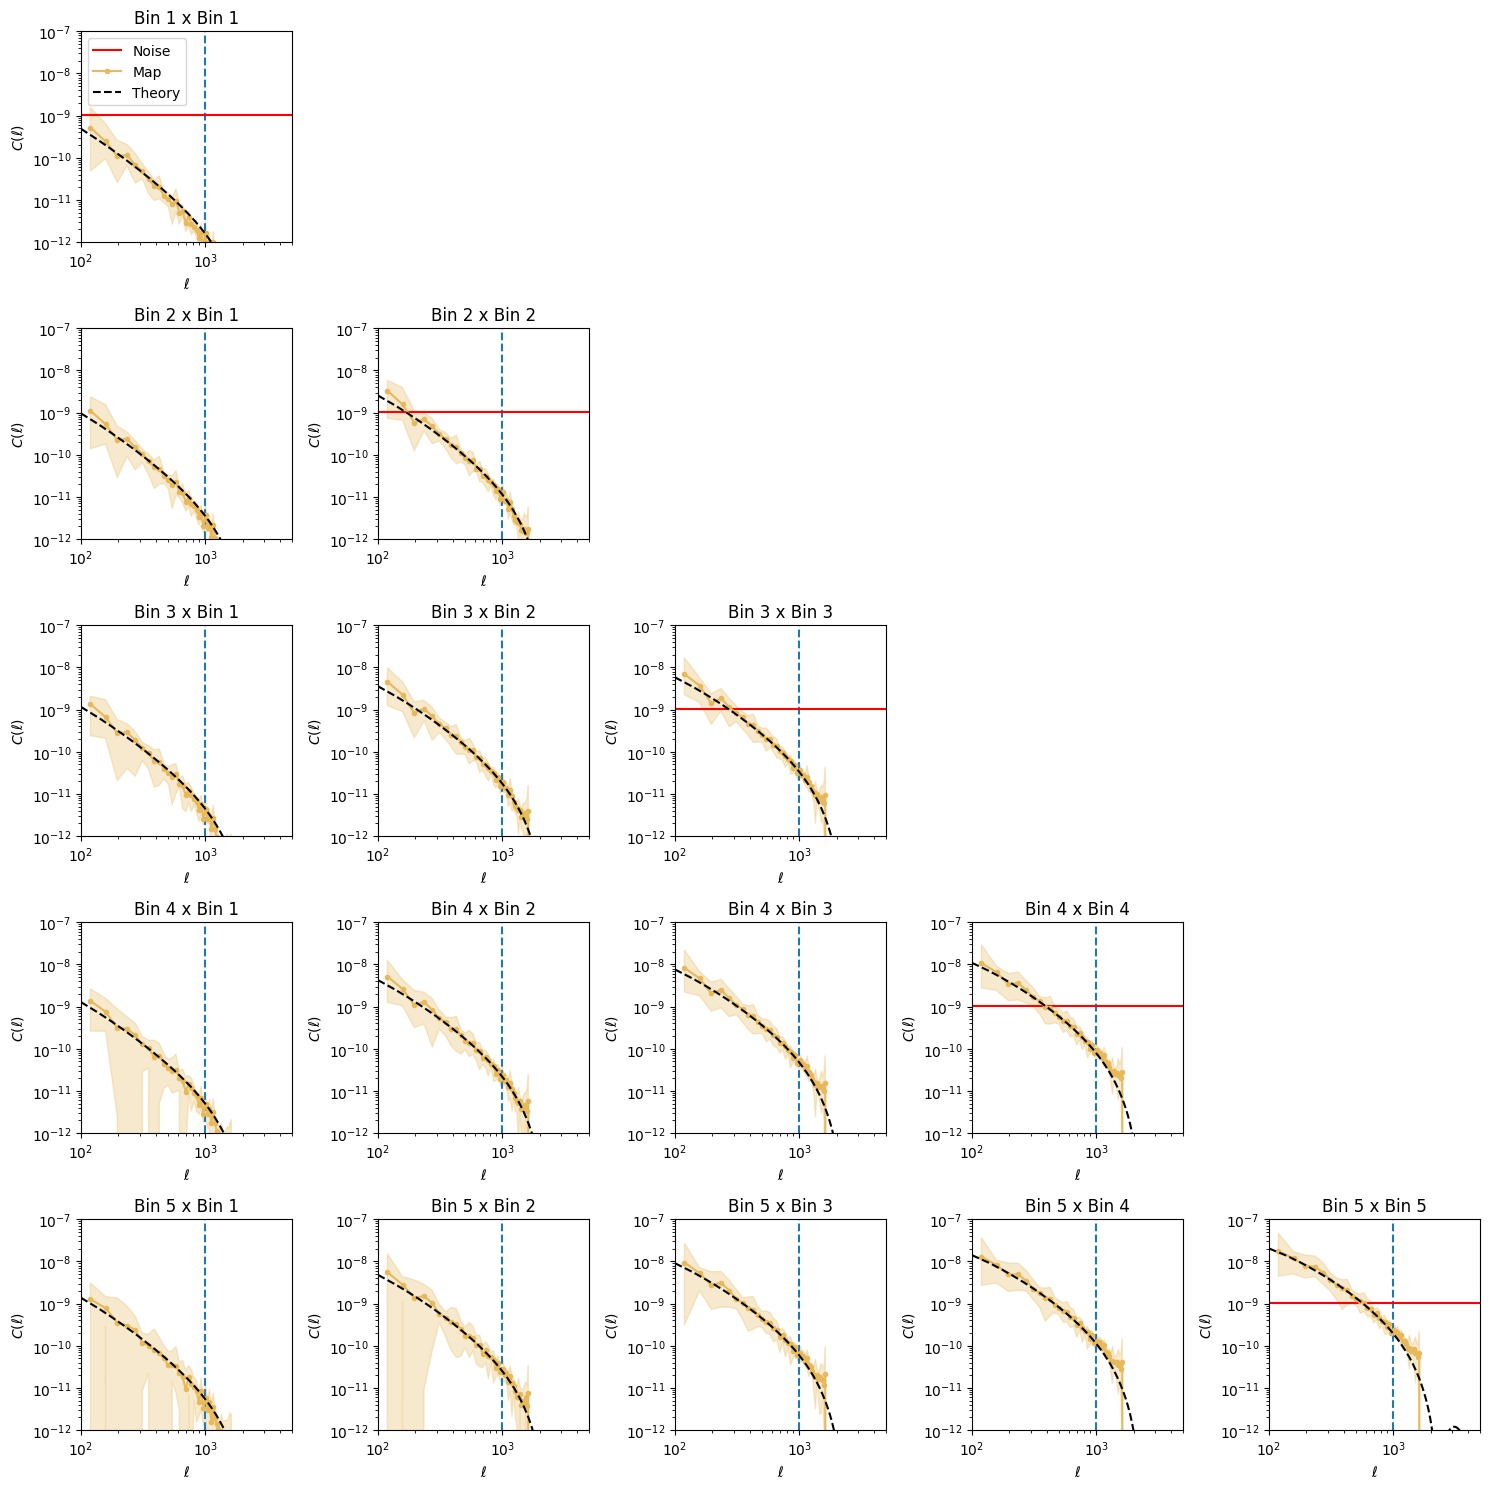

In [75]:
# 256 resolution - linear matter power theory - 32 pixels
fig, ax = plt.subplots(n_z_bins, n_z_bins, figsize=(15,15))

for i in range(n_z_bins):
    for j in range(n_z_bins):
        if(j>i):
            ax[i,j].axis('off')
        else:
            ax[i,j].set_title('Bin %d x Bin %d'%(i+1,j+1))
            ax[i,j].set_xlabel('$\ell$')
            ax[i,j].set_ylabel('$C(\ell)$')
            ax[i,j].set_xlim(100., 5000.)
            ax[i,j].set_ylim(1e-12, 1e-7)
            ax[i,j].axvline(1000, ls='--')
            ax[i,j].loglog(ell_theory, Cl_noise_theory[:,i,j], label='Noise', color='red')
            if i==j:
                ax[i,j].loglog(ell_sample, Cl_mean_auto[i], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_auto[i], Cl_upper_auto[i], color=col[3], alpha=0.3)
            else:
                ax[i,j].loglog(ell_sample, Cl_mean_sample_cross[:,i,j], '.-', color=col[3], label='Map')
                ax[i,j].loglog(ell_theory, Cl_mean_theory[:,i,j], '--',  color=col[1], label='Theory')
                ax[i,j].fill_between(ell_sample, Cl_lower_sample_cross[:, i,j], Cl_upper_sample_cross[:,i,j], color=col[3], alpha=0.3)

ax[0,0].legend()
plt.tight_layout()
plt.show()